### 1. Laden Sie die Trainingsdaten.

Die Trainingsdaten werden über die `read_csv()` Funktion geladen, dabei kann der Trenner (sepperator) über den Parameter `sep=";"` festgelegt werden.
Zu Anfang ist es immer sinnvoll sich die Daten einmal anzuschauen um ein gefühl dafür zu bekommen mit was man arbeitet. Außerdem können so auch Fehler erkannt werden, beispielsweise ob die Daten richtig geladen wurden oder nicht.

In [ ]:
import pandas as pd

# Trainingsdaten aus csv laden, der seperator ist hier allerdings ein ';'
data_train = pd.read_csv("./data/project/train.csv", sep=";")

data_train.head()

: 

#### 2. Führen Sie eine kurze EDA durch (Details auf Slide 14).

**Exploratory Data Analysis** oder kurz **EDA** ist der Prozess Daten über verschiedene Darstellungen, primär grafische Darstellungen, zu betrachten um einen überblick zu erlangen und erste Muster oder Abweichungen zu erkennen oder auch Hypothesen und Annahmen zu prüfen.


- `figsize`: die Größe des Plottes der angezeigt werden soll
- `rot`: die Rotation des Textes im Plot

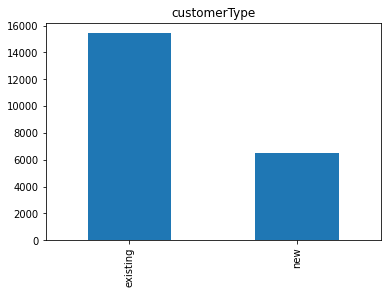

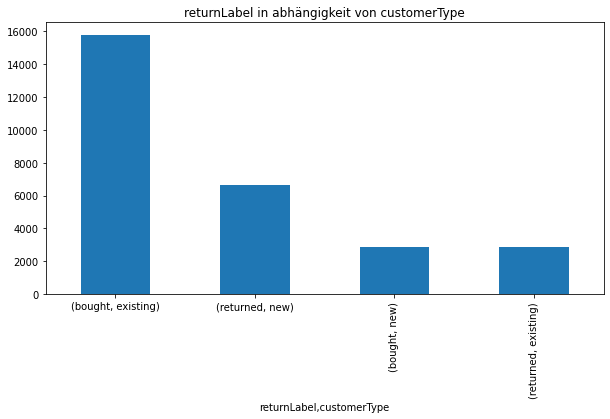

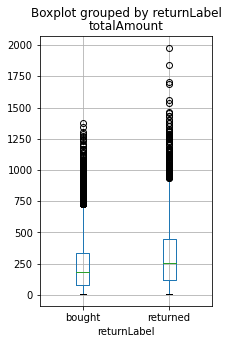

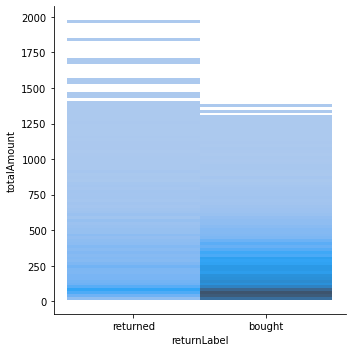

In [3]:
import seaborn as sns

plotable_data = data_train

plotable_data['returnLabel'] = plotable_data['returnLabel'].replace({0:'bought',1:'returned'})

# histogram für 'customerType' 
plotable_data['customerType'].value_counts().plot(kind='bar', title='customerType')

# histogram für 'totalAmount'
plotable_data.hist(column='totalAmount')

# verteilung von returnLabel als plot
plotable_data['returnLabel'].value_counts().plot(kind='bar', title='returnLabel')

# return label in abhängigkeit von customerType plotten
# figsize ist groesse des plots
# rot ist die rotation des Textes an der Achse
plotable_data[['returnLabel','customerType']].value_counts().plot.bar(rot=0,figsize=(10,5),title='returnLabel in abhängigkeit von customerType')

# boxplot für 'totalAmount' in Abhängigkeit von 'returnLabel'
plotable_data.boxplot(column='totalAmount', by='returnLabel',figsize=(3,5))
sns.displot(plotable_data, x='returnLabel', y='totalAmount', kind='hist')


#### 3. Füllen Sie fehlende Werte in den Trainingsdaten auf.

Hier werden alle Zeilen aufgefüllt, in denen `totalAmount` keinen Wert, bzw einen ungültigen Wert besitzt. Dazu wird der Durchschnitt der übrigen Werte genutzt. Der Durchschnitt wird genutzt da dieser die Gewichtung des Kompletten Datensatzes nicht beeinflusst.

Es wird ausschließlich `totalAmount` aufgefüllt, da `totalAmount` ein nummerischer Wert ist. Alle anderen Feature, welche auch bereinigt werden müssen, werden auf eine andere Art und Weise behandelt, da es sich bei diesen nicht um nummerische sondern kategorische Feature handelt. 

In [4]:
# warum füllen wir die ausgewählten trainingsdaten auf und nicht die andern?
# hier wird der median genutzt um die null Werte von totalAmount zu ersetzen, der Durchschnitt wird genutzt da dieser keine verzerrung der tendenzen der daten einfuehrt
# customerType wird später beim OnehotEncoding bearbeitet und die null values dadurch entfernt

print(data_train.isnull().sum())
data_train['totalAmount'].fillna(data_train['totalAmount'].mean(), inplace=True)
print(data_train.isnull().sum())

transactionId      0
basket             0
customerType     442
totalAmount      477
returnLabel        0
dtype: int64
transactionId      0
basket             0
customerType     442
totalAmount        0
returnLabel        0
dtype: int64


#### 4. Transformieren Sie die kategorischen Features mittels One-hot-encoding.

Hier werden die kategorischen Features `customerType` und `returnLabel` "One-hot-encoded". Das heißt jedes kategorische Feature wird in mehrere Feature transformiert, um genau zu sein in so viele wie es kategorien in dem Featrue gibt.\
One-hot-encoding bietet den Vorteil, dass auch Tupel/Zeilen zum lernen verwendet werden können, in denen die Datenpunkte fehlen.\
Wir teilen wie folgt auf:
- `customerType` :
    - `is_new_customer` => 1 wenn `customerType` = "new", ansonsten 0
    - `is_existing_customer` => 1 wenn `customerType` = "existing", ansonsten 0

Da in `returnLabel` keine Daten fehlen und es sich um eine binäre klassifizierung handelt ist ein klassisches One-hot-encoding nicht nötig. Statdessen wird direkt in `was_returned` transformiert.
- `returnLabel`
    - `was_returned` => 1 wenn `returnLabel` = "returned", 0 falls `returnLabel` = "bought"

In [5]:
# berechne feature und füge die berechneten feature dem DatenFrame hinzu
data_train['is_new_customer'] = data_train['customerType'].replace({'existing': 0, 'new': 1}).fillna(0)
data_train['is_existing_customer'] = data_train['customerType'].replace({'existing': 1, 'new': 0}).fillna(0)
data_train['was_returned'] = data_train['returnLabel'].replace({'bought': 0, 'returned': 1})

# nicht benötigte feature löschen
data_train.drop(['customerType'], axis=1, inplace=True)
data_train.drop(['returnLabel'], axis=1, inplace=True)

# datensatz anschauen
data_train.head()

,transactionId,basket,totalAmount,is_new_customer,is_existing_customer,was_returned
0,9534310106,"[4, 3, 4]",252.0,1.0,0.0,1
1,7202594767,"[4, 2, 0, 2, 5]",70.0,0.0,1.0,0
2,2737331698,[5],84.0,0.0,1.0,0
3,4868011733,"[1, 4, 2, 4]",116.0,0.0,1.0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",378.0,0.0,1.0,0


#### 5. Versuchen Sie auf Basis des Attributs basket Features zu bauen (z.B. wie oft kommt jede Kategorie im Basket vor)

In diesem Teil werden geeignete Features aus dem Feature `basket` erzeugt:

| Feature       | Beschreibung                                                          |
|---------------|-----------------------------------------------------------------------|
| `zero_count`  | die Anzahl von bestellten Büchern der Kategorie 0                     |
| `one_count`   | die Anzahl von bestellten Büchern der Kategorie 1                     |
| `two_count`   | die Anzahl von bestellten Büchern der Kategorie 2                     |
| `three_count` | die Anzahl von bestellten Büchern der Kategorie 3                     |
| `four_count`  | die Anzahl von bestellten Büchern der Kategorie 4                     |
| `five_count`  | die Anzahl von bestellten Büchern der Kategorie 5                     |
| `max_count`   | die maximale Anzahl von bestellten Büchern aus der gleichen Kategorie |
| `basket_size` | die Anzahl von bestellten Büchern                                     |


Hier wird oft die .map() Funktion genutz. Map is eine Funktion die jedem Element einer Menge einen neuen Wert zuordnet. Dieser wert wird über die übergebene lamda funktion ermittelt. 
Für `zero_count` sieht die Funktion wie folgt aus (x entspricht hierbei einem Basket, bspw: [1,2,4,5,0]):\
x ⟼ x.count('0')

In [6]:
# warum nutzten wir diese feature, was könnte man noch für feature benutzen? => warum haben wir sie nicht benutzt?

# berechne feature und füge die berechneten feature dem DatenFrame hinzu
data_train['zero_count'] = data_train.basket.map(lambda x: x.count('0'))
data_train['one_count'] = data_train.basket.map(lambda x: x.count('1'))
data_train['two_count'] = data_train.basket.map(lambda x: x.count('2'))
data_train['three_count'] = data_train.basket.map(lambda x: x.count('3'))
data_train['four_count'] = data_train.basket.map(lambda x: x.count('4'))
data_train['five_count'] = data_train.basket.map(lambda x: x.count('5'))

data_train['basket_size'] = data_train.basket.map(lambda x: x.count('0') + x.count('1') + x.count('2') + x.count('3') + x.count('4') + x.count('5'))

data_train['max_count'] = data_train.basket.map(lambda x: max(x.count('0'), x.count('1'), x.count('2'), x.count('3'), x.count('4'), x.count('5')))

# nicht benötigte feature löschen
data_train.drop(['basket'], axis=1, inplace=True)

# datensatz anschauen
data_train.head()

,transactionId,totalAmount,is_new_customer,is_existing_customer,was_returned,zero_count,one_count,two_count,three_count,four_count,five_count,basket_size,max_count
0,9534310106,252.0,1.0,0.0,1,0,0,0,1,2,0,3,2
1,7202594767,70.0,0.0,1.0,0,1,0,2,0,1,1,5,2
2,2737331698,84.0,0.0,1.0,0,0,0,0,0,0,1,1,1
3,4868011733,116.0,0.0,1.0,0,0,1,1,0,2,0,4,2
4,7622406570,378.0,0.0,1.0,0,1,0,3,2,0,1,7,3


Zusätzlich sollten alle Feature entfernt werden, welche offensichtlich kein zusammenhang mit der vorhersage haben, das ist in unserm Fall nur die `transactionId`.

In [7]:
data_train.drop(['transactionId'], axis=1, inplace=True)

#### 6. Skalieren Sie die Features mit einem StandardScaler.

In [8]:
from sklearn.preprocessing import StandardScaler
X_train = data_train.drop(['was_returned'], axis=1)
Y_train = data_train['was_returned']
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
#data_scaled[data_train.columns] = scaler.transform(data_train[data_train.columns])
print(X_scaled)






[[-0.03282349  1.55861197 -1.48725587 ... -0.64410553 -0.60727524
  -0.13935946]
 [-0.87945944 -0.64159651  0.67237926 ...  0.52709049  0.13320354
  -0.13935946]
 [-0.8143336  -0.64159651  0.67237926 ...  0.52709049 -1.34775403
  -1.01426189]
 ...
 [-0.04677903  1.55861197 -1.48725587 ... -0.64410553 -0.60727524
  -1.01426189]
 [-0.83294098 -0.64159651  0.67237926 ...  2.86948253  1.24392171
   0.73554297]
 [ 1.08361952  1.55861197 -1.48725587 ... -0.64410553 -0.23703585
  -0.13935946]]


### 7. Trainieren Sie die folgenden Klassifikationsmodelle und probieren Sie die angegebenen Hyperparameter mittels Cross-Validation aus:

##### 7.1. Logistische Regression: C :[0.1,1,4,5,6,10,30,100] und penalty: ["l1", "l2"]

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
parameters = {'C': [0.1,1,4,5,10,30,100], 'penalty': ["l1","l2"]}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), parameters, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_scaled, Y_train)
logReg_best_params = grid_search.best_params_
print(logReg_best_params)

{'C': 1, 'penalty': 'l1'}


#### 7.2. Random Forest: n_estimators: [60,80,100,120,140] und max_depth: [2, 4, 6]


##### 7.3. Gradient Boosting Tree: gleiche Hyperparameter wie bei Random Forest.

### 8. Laden Sie die Testdaten.

### 9. Entfernen Sie alle Zeilen mit fehlenden Werten.

### 10. Transformieren Sie die Attribute genauso wie bei den Trainingsdaten.

### 11. Skalieren Sie die Daten im gleichem Maß wie die Trainingsdaten.

### 12. Machen Sie eine Vorhersage auf den Testdaten mit allen drei Modellen und den jeweils besten Hyperparametern aus der Cross Validation.

### 13. Berechnen Sie für jedes der drei Modell Accuracy, Precision und Recall.

### 14. Berechnen Sie außerdem die Accuracy auf den Trainingsdaten und vergleichen Sie Accuracy auf Trainings- und Testdaten. Liegt Overfitting vor?

### 15. Untersuchen Sie wieviele Datenpunkte es in den Testdaten gibt, welche von allen drei Modellen falsch klassifiziert wurden:

#### 1. Bestimmen Sie für jedes der drei Modelle die Indizes der Testdatenpunkte auf welchen das jeweilige Modell falsch klassifiziert hat.

#### 2. Nutzen Sie die set-Klasse in Python um die Anzahl an Datenpunkten zu bestimmen, welche von allen drei Modellen falsch klassifiziert wurden.